<a href="https://colab.research.google.com/github/Nitishgautam21/Zeoptap-Assignment/blob/initial-branch/Nitish_Gautam_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules and Libraries

In [376]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler


# Merging and Preprocessing Datasets

In [377]:
# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert date columns to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Merge datasets on 'CustomerID'
df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

In [378]:
df.head(5)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [379]:
 # Dropping rows with NaN values (if applicable)
 df = df.dropna()

In [380]:
# Fetching columns
df.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')

# Feature Engineering

In [381]:
# Step 1: Feature Engineering

# 1. Calculate Recency (days since last purchase)
recency = df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (df['TransactionDate'].max() - recency['TransactionDate']).dt.days

# Merge Recency into features
features = recency[['CustomerID', 'Recency']]

# 2. Calculate Frequency (number of transactions)
frequency = df.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency = frequency.rename(columns={'TransactionID': 'Frequency'})

# Merge Frequency into features
features = features.merge(frequency, on='CustomerID')

# 3. Calculate Monetary (total spend)
monetary = df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary = monetary.rename(columns={'TotalValue': 'Monetary'})

# Merge Monetary into features
features = features.merge(monetary, on='CustomerID')

# 4. Calculate Total Products Purchased
total_products = df.groupby('CustomerID')['ProductID'].nunique().reset_index()
total_products = total_products.rename(columns={'ProductID': 'UniqueProducts'})

# Merge UniqueProducts into features
features = features.merge(total_products, on='CustomerID')

In [382]:
features.head(5)

,CustomerID,Recency,Frequency,Monetary,UniqueProducts
0,C0001,55,5,3354.52,5
1,C0002,25,4,1862.74,4
2,C0003,125,4,2725.38,4
3,C0004,4,8,5354.88,8
4,C0005,54,3,2034.24,3


In [383]:
features.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'UniqueProducts'], dtype='object')

# Standardizing the features

In [384]:
# Step 2: Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features[['Recency', 'Frequency', 'Monetary', 'UniqueProducts']])

# Finding Best value of K (Number of Clusters) for Clustering  

Optimal number of clusters (k): 3
Minimum Davies-Bouldin Index (DBI): 0.8188531629166617


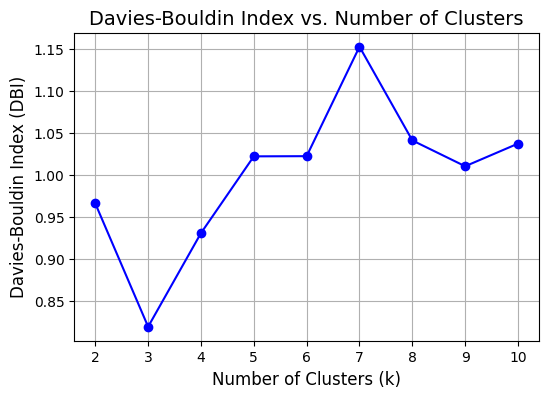

In [391]:
import plotly.express as px
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

# Step 2: Find the best k with minimum DBI
dbi_scores = []

# Test different values of k (from 2 to 10)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++',random_state=42)
    features['Cluster'] = kmeans.fit_predict(features_scaled)

    # Calculate DBI for the current k
    dbi = davies_bouldin_score(features_scaled, features['Cluster'])
    dbi_scores.append(dbi)

# Find the best k with the minimum DBI
best_k = range(2, 11)[dbi_scores.index(min(dbi_scores))]
min_dbi = min(dbi_scores)

print(f"Optimal number of clusters (k): {best_k}")
print(f"Minimum Davies-Bouldin Index (DBI): {min_dbi}")

# Step 3: Plot DBI vs. number of clusters (k)
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), dbi_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Davies-Bouldin Index (DBI)', fontsize=12)
plt.grid(True)
plt.xticks(range(2, 11))
plt.show()


# Performing KMeans clustering with the best k

In [389]:
# Step 1: Perform KMeans clustering with the best k
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42)
features['Cluster'] = kmeans.fit_predict(features_scaled)

# Step 3: Check how many data points are in each cluster
cluster_counts = features['Cluster'].value_counts()
print(f"Cluster counts:\n{cluster_counts}")


Cluster counts:
Cluster
1    113
0     72
2     14
Name: count, dtype: int64


# Dimensionality reduction using PCA for visualizing Clusters in 3D space

In [390]:
# Reduce dimensions to 3D using PCA
pca_3d = PCA(n_components=3)
features_pca_3d = pca_3d.fit_transform(features_scaled)

# Create a DataFrame for visualization
visualization_df_3d = pd.DataFrame(features_pca_3d, columns=['PCA1', 'PCA2', 'PCA3'])
visualization_df_3d['Cluster'] = features['Cluster']
visualization_df_3d['CustomerID'] = features['CustomerID']

# Plotly 3D scatter plot with hover data showing CustomerID
import plotly.express as px

fig = px.scatter_3d(
    visualization_df_3d,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    title='3D Visualization of Customer Clusters',
    labels={'Cluster': 'Cluster'},
    opacity=0.8,
    hover_data={'CustomerID': True, 'Cluster': True}  # Display CustomerID and Cluster on hover
)

# Show the plot
fig.show()

# Analysis of each cluster

In [387]:
# Calculate total spend by each cluster
features['TotalSpend'] = df.groupby('CustomerID')['TotalValue'].transform('sum')

# Calculate average Recency, Frequency, Unique Products by cluster
cluster_summary = features.groupby('Cluster').agg({
    'TotalSpend': 'sum',           # Total spend for each cluster
    'Recency': 'mean',             # Average recency for each cluster
    'Frequency': 'mean',           # Average frequency for each cluster
    'UniqueProducts': 'mean'       # Average unique products for each cluster
}).reset_index()

# Display the summary dataframe
cluster_summary



,Cluster,TotalSpend,Recency,Frequency,UniqueProducts
0,0,306168.13,53.430556,7.319444,7.069444
1,1,425732.10,64.345133,4.008850,3.946903
2,2,52523.73,256.142857,1.428571,1.357143


# Clustering Metrics

In [388]:
# silhouette score
silhouette_avg = silhouette_score(features_scaled, features['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index
dbi = davies_bouldin_score(features_scaled, features['Cluster'])
print(f"Davies-Bouldin Index: {dbi}")

# Calinski-Harabasz Index
ch_index = calinski_harabasz_score(features_scaled, features['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index}")

Silhouette Score: 0.3914824972690587
Davies-Bouldin Index: 0.8188531629166617
Calinski-Harabasz Index: 161.80693892188498
